In [2]:
import sys
sys.path.append('../')
import os
os.environ['DDE_BACKEND']="pytorch"


import deepxde as dde
import numpy as np
Re = 20
nu = 1 / Re
l = 1 / (2 * nu) - np.sqrt(1 / (4 * nu ** 2) + 4 * np.pi ** 2)


def pde(x, u):
    u_vel, v_vel, p = u[:, 0:1], u[:, 1:2], u[:, 2:]
    u_vel_x = dde.grad.jacobian(u, x, i=0, j=0)
    u_vel_y = dde.grad.jacobian(u, x, i=0, j=1)
    u_vel_xx = dde.grad.hessian(u, x, component=0, i=0, j=0)
    u_vel_yy = dde.grad.hessian(u, x, component=0, i=1, j=1)

    v_vel_x = dde.grad.jacobian(u, x, i=1, j=0)
    v_vel_y = dde.grad.jacobian(u, x, i=1, j=1)
    v_vel_xx = dde.grad.hessian(u, x, component=1, i=0, j=0)
    v_vel_yy = dde.grad.hessian(u, x, component=1, i=1, j=1)

    p_x = dde.grad.jacobian(u, x, i=2, j=0)
    p_y = dde.grad.jacobian(u, x, i=2, j=1)

    momentum_x = (
        u_vel * u_vel_x + v_vel * u_vel_y + p_x - 1 / Re * (u_vel_xx + u_vel_yy)
    )
    momentum_y = (
        u_vel * v_vel_x + v_vel * v_vel_y + p_y - 1 / Re * (v_vel_xx + v_vel_yy)
    )
    continuity = u_vel_x + v_vel_y

    return [momentum_x, momentum_y, continuity]


def u_func(x):
    return 1 - np.exp(l * x[:, 0:1]) * np.cos(2 * np.pi * x[:, 1:2])


def v_func(x):
    return l / (2 * np.pi) * np.exp(l * x[:, 0:1]) * np.sin(2 * np.pi * x[:, 1:2])


def p_func(x):
    return 1 / 2 * (1 - np.exp(2 * l * x[:, 0:1]))


def boundary_outflow(x, on_boundary):
    return on_boundary and np.isclose(x[0], 1)


spatial_domain = dde.geometry.Rectangle(xmin=[-0.5, -0.5], xmax=[1, 1.5])

boundary_condition_u = dde.icbc.DirichletBC(
    spatial_domain, u_func, lambda _, on_boundary: on_boundary, component=0
)
boundary_condition_v = dde.icbc.DirichletBC(
    spatial_domain, v_func, lambda _, on_boundary: on_boundary, component=1
)
boundary_condition_right_p = dde.icbc.DirichletBC(
    spatial_domain, p_func, boundary_outflow, component=2
)

data = dde.data.TimePDE(
    spatial_domain,
    pde,
    [boundary_condition_u, boundary_condition_v, boundary_condition_right_p],
    num_domain=2601,
    num_boundary=400,
    num_test=100000,
)

net = dde.nn.FNN([2] + 4 * [50] + [3], "tanh", "Glorot normal")

model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=10000)
# model.compile("L-BFGS")
# losshistory, train_state = model.train()

X = spatial_domain.random_points(10000)
output = model.predict(X)
u_pred = output[:, 0]
v_pred = output[:, 1]
p_pred = output[:, 2]

u_exact = u_func(X).reshape(-1)
v_exact = v_func(X).reshape(-1)
p_exact = p_func(X).reshape(-1)

f = model.predict(X, operator=pde)

l2_difference_u = dde.metrics.l2_relative_error(u_exact, u_pred)
l2_difference_v = dde.metrics.l2_relative_error(v_exact, v_pred)
l2_difference_p = dde.metrics.l2_relative_error(p_exact, p_pred)
residual = np.mean(np.absolute(f))

print("Mean residual:", residual)
print("L2 relative error in u:", l2_difference_u)
print("L2 relative error in v:", l2_difference_v)
print("L2 relative error in p:", l2_difference_p)

Compiling model...
'compile' took 0.002051 s

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [6.05e-02, 2.74e-02, 1.18e-01, 3.39e+00, 1.04e-01, 1.14e-01]    [6.13e-02, 2.72e-02, 1.22e-01, 3.39e+00, 1.04e-01, 1.14e-01]    []  
1000      [2.62e-02, 8.54e-03, 1.14e-02, 7.43e-02, 2.18e-02, 4.46e-04]    [1.91e-02, 5.46e-03, 7.94e-03, 7.43e-02, 2.18e-02, 4.46e-04]    []  
2000      [3.90e-03, 2.42e-03, 2.52e-03, 7.71e-03, 3.06e-03, 2.56e-04]    [2.29e-03, 1.76e-03, 2.01e-03, 7.71e-03, 3.06e-03, 2.56e-04]    []  
3000      [3.59e-03, 8.04e-04, 9.48e-04, 2.34e-03, 1.27e-03, 9.46e-05]    [2.74e-03, 6.79e-04, 7.79e-04, 2.34e-03, 1.27e-03, 9.46e-05]    []  
4000      [3.17e-03, 6.66e-04, 5.01e-04, 8.95e-04, 5.94e-04, 1.90e-05]    [2.60e-03, 6.05e-04, 4.76e-04, 8.95e-04, 5.94e-04, 1.90e-05]    []  
5000      [7.51e-04, 3.56e-04, 2.79e-04, 2.68e-04, 3.47e-04, 7.94e-06]

0.0076114587
0.01792987
0.010982264


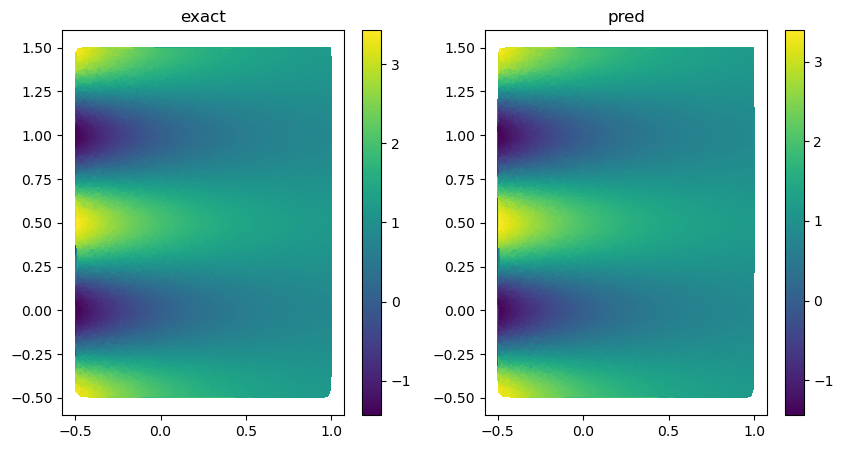

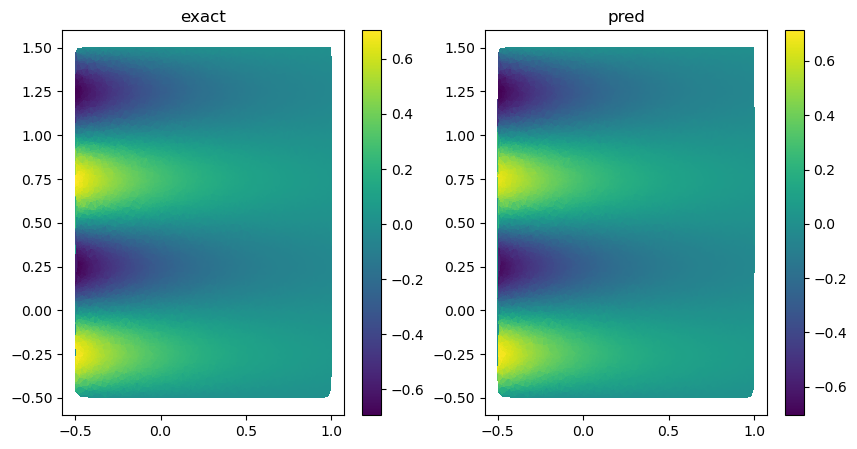

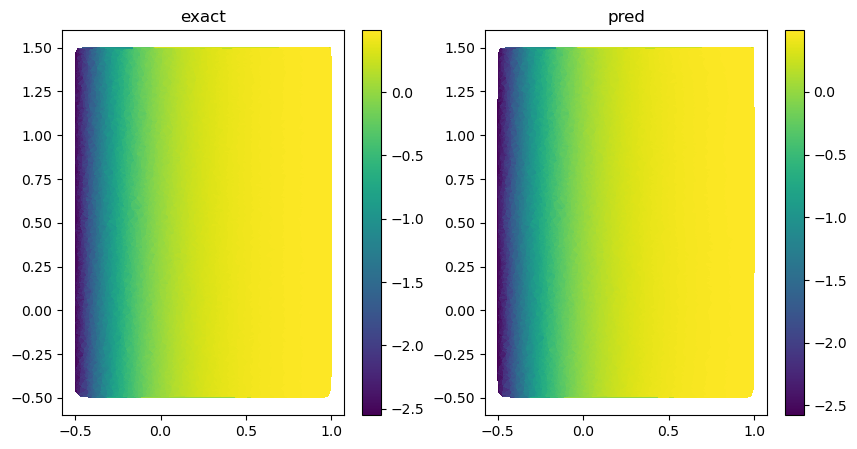

In [18]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

def plot_u(x,y,u_exact,u_pred):
    fig,(ax1,ax2) = plt.subplots(1,2,figsize =[10,5] )

    triang = tri.Triangulation(x,y)
    tpc = ax1.tripcolor(triang,u_exact , shading='flat')
    fig.colorbar(tpc,ax=ax1)
    ax1.set_title('exact')

    tpc = ax2.tripcolor(triang,u_pred , shading='flat')
    fig.colorbar(tpc,ax=ax2)
    ax2.set_title('pred')
    print(np.mean(np.abs(u_exact-u_pred))/np.std(u_exact))

plot_u(X[:,0], X[:,1], u_exact, u_pred)
plot_u(X[:,0], X[:,1], v_exact, v_pred)
plot_u(X[:,0], X[:,1], p_exact, p_pred)
